# Zigzag OBC

In [27]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global n, m, N, a1
n = 3 # unit cell number in x direction
m = 10 # unit cell number in y direction
N = 2*n*m
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2

def ni(i):
    # new index
    # transform from 0, 1, 2, ..., N-1 to 0, 2, 4, ..., 1, 3, 5, ...
    if i % 2 == 0:
        return int(i/2)
    else:
        return int((i-1)/2 + N/2)
    # return i

def hamiltonian(j, J, d, h, k, d2=-10, boundary_site1='A', boundary_site2='B'):
    
    mat = np.zeros((N,N), dtype=np.complex128)
    
    A = []
    B = []
    for i in range(n*m):
        A.append(i*2)
        B.append(i*2 + 1)
    
    phase = lambda a : np.exp(1j * k * a)
    n2 = 2*n
    if d2 == -10:
        d2 = d
    else: pass
    
    def labels(i):
        
        l = math.floor(i/(2*n))
        row = n2*l 
        rowp = 2*n*((l+1)%m)
        rowm = 2*n*((l-1)%m)
        x, y = (i+n2)%N, (i-n2)%N
        
        return row, rowp, rowm, x, y
        
    ''' Periodic boundary condition '''

    for i in A:
        row, rowp, rowm, x, y = labels(i)
        
        mat[ni(i), ni(i)] += 3*j+6*J+h
        
        # nearest neighbors
        mat[ni(i), ni(i+1)] += -j*phase(a1)
        mat[ni(i), ni((i-1)%n2+row)] += -j*phase(-a1)
        mat[ni(i), ni((i-2*n+1)%N)] += -j
        
        # next nearest neighbors
        mat[ni(i), ni((i+2)%n2+row)] += (-J-d*1j)*phase(2*a1)
        mat[ni(i), ni((i-2)%n2+row)] += (-J+d*1j)*phase(-2*a1)
        mat[ni(i), ni(x)] += (-J+d*1j)*phase(a1)
        mat[ni(i), ni((x-2)%n2+rowp)] += (-J-d*1j)*phase(-a1)
        mat[ni(i), ni(y)] += (-J-d*1j)*phase(-a1)
        mat[ni(i), ni((y+2)%n2+rowm)] += (-J+d*1j)*phase(a1)
        
    for i in B:
        row, rowp, rowm, x, y = labels(i)
        
        mat[ni(i), ni(i)] = 3*j+6*J+h
        
        # nearest neighbors
        mat[ni(i), ni(i-1)] += -j*phase(-a1)
        mat[ni(i), ni((i+1)%n2+row)] += -j*phase(a1)
        mat[ni(i), ni((i+2*n-1)%N)] += -j
        
        # next nearest neighbors
        mat[ni(i), ni((i+2)%n2+row)] += (-J+d2*1j)*phase(2*a1)
        mat[ni(i), ni((i-2)%n2+row)] += (-J-d2*1j)*phase(-2*a1)
        mat[ni(i), ni(x)] += (-J-d2*1j)*phase(a1)
        mat[ni(i), ni((x-2)%n2+rowp)] += (-J+d2*1j)*phase(-a1)
        mat[ni(i), ni(y)] += (-J+d2*1j)*phase(-a1)
        mat[ni(i), ni((y+2)%n2+rowm)] += (-J-d2*1j)*phase(a1)

    ''' Open boundary condition (in y direction)'''
    
    for i in A[:n]: # first layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni((i-2*n+1)%N)] = 0
        
        mat[ni(i), ni(y)] = 0
        mat[ni(i), ni((y+2)%n2+rowm)] = 0
    
    for i in B[:n]: # second layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni(y)] = 0
        mat[ni(i), ni((y+2)%n2+rowm)] = 0
    
    for i in B[-n:]: # last layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni((i+2*n-1)%N)] = 0
        
        mat[ni(i), ni(x)] = 0
        mat[ni(i), ni((x-2)%n2+rowp)] = 0
        
    for i in A[-n:]: # second last layer
        row, rowp, rowm, x, y = labels(i)
        
        mat[ni(i), ni(x)] = 0
        mat[ni(i), ni((x-2)%n2+rowp)] = 0
        
    ''' Different boundary sites '''
    sites_tobe_removed = [0, N]
            
    if boundary_site1 == 'A':
        pass 
    elif boundary_site1 == 'B':
        sites_tobe_removed[0] = n
        for i in B[:n]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(i-1)] = 0
            mat[ni(i), ni((i+1)%n2+row)] = 0
            
            mat[ni(i), ni((i+2)%n2+row)] = 0
            mat[ni(i), ni((i-2)%n2+row)] = 0
            
        for i in A[n:2*n]:
            row, rowp, rowm, x, y = labels(i)
            
            mat[ni(i), ni(y)] = 0
            mat[ni(i), ni((y+2)%n2+rowm)] = 0
    else:
        print('Error: boundary_site1 should be A or B')
        return
    
    if boundary_site2 == 'B':
        pass
    elif boundary_site2 == 'A':
        sites_tobe_removed[1] = N-n
        for i in A[-n:]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(i+1)] = 0
            mat[ni(i), ni((i-1)%n2+row)] = 0
            
            mat[ni(i), ni((i+2)%n2+row)] = 0
            mat[ni(i), ni((i-2)%n2+row)] = 0
            
        for i in B[-2*n:-n]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(x)] = 0
            mat[ni(i), ni((x-2)%n2+rowp)] = 0
    else:
        print('Error: boundary_site2 should be A or B')
        return
        
    return mat[sites_tobe_removed[0]: sites_tobe_removed[1], sites_tobe_removed[0]: sites_tobe_removed[1]]/2
    # print(sites_tobe_removed)
    return mat/2

def delta_function(x, res=100):
    
    e = 2/res
    D = e/(e**2 + x**2) * 1/np.pi
    return D

def eigenv(Jn, JN, D, h, k, d2=-10, boundary_site1='A', boundary_site2='B'):
    '''  setup eigenvalues and eigenvectors
    parameters:
        Jn: float
            nearest neighbor interaction
        JN: float
            next nearest neighbor interaction
        D: float
            Dzyaloshinskii-Moriya interaction
        h: float
            magnetic field
        k: float
            momentum
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_str: np.ndarray
            conjugated eigenvectors
    '''
    H = hamiltonian(Jn, JN, D, h, k, d2, boundary_site1, boundary_site2)
    
    E, U = np.linalg.eig(H)
    # E -= np.min(E)+1e-10 # shift to positive
    # print(f'Eigenvalue: {E}')
    # U_str = np.conjugate(U)
    
    # return E, U, U_str
    return E
    
def build_basis(x, y):
    ''' build basis and lattice coordinates
    parameters:
        x: int
            number of unit cells in x direction
        y: int
            number of unit cells in y direction
    returns: 
        r: np.ndarray
            lattice coordinates
    '''

    r = []
  
    for j in range(y):
        for i in range(x):
            r.append([3**0.5*(i + j/2), 3/2*j ])
            r.append([3**0.5*(i + j/2) + 1/3*(3**0.5*(1 + 1/2)), 3/2*j + 1/3*(3/2)])
  
    return np.array(r)

def DSF(j, J, D, h, W, T, b1, b2, n1, n2, res, mode='-+'):
    ''' compute dynamical structure factor
    parameters:
        j: float
            nearest neighbor interaction
        J: float
            next nearest neighbor interaction
        D: float
            Dzyaloshinskii-Moriya interaction
        h: float
            magnetic field
        W: list
            energy grid
        T: float
            temperature
        b1: list
            basis vector 1
        b2: list
            basis vector 2
        n1: int
            momentum index 1
        n2: int
            momentum index 2
        mode: str
            spin correlation mode, '-+' or 'zz'
    returns:
        E_m: list
            eigenvalues
        x: np.ndarray
            dynamical structure factor on energy grid W
    '''
    
    r = build_basis(n, m)

    Q = np.zeros(2)
    Q[0] = b1[0]*n1/n + b2[0]*n2/m
    Q[1] = b1[1]*n1/n + b2[1]*n2/m

    E_m, U, U_str = eigenv(j, J, D, h)
    
    # Z = 0
    # for E in E_m:
    #     Z += np.exp(-E/T)
    
    x = []
    
    for w in W:
        sum_ijm = np.complex128(0)
        
        for l, E in enumerate(E_m):
            if mode == '+-':
                delta = delta_function(w - E, res)
                nB = 1/(np.exp(E/T) - 1) + 1
            elif mode == '-+':
                delta = delta_function(w + E, res)
                nB = 1/(np.exp(E/T) - 1)
            
            for i in range(N):
                for k in range(N):
                    rij = r[i] - r[k]
                    UU = U[ni(i), l] * U_str[ni(k), l]
                    phase = np.exp(-1j * (Q[0]*rij[0] + Q[1]*rij[1]))
                    sum_ijm += phase * UU * nB * delta
            
            # print(sum_ijm)
                    
        x.append(sum_ijm/(2*np.pi*N))
        
    return E_m, Q, np.array(x)
    
j = 1
J = 0.0
# D = 0.1
# D2 = D
D = -0.1+0.001
D2 = 0.1+0.001
h = 0.1
T = 0.1

k1 = np.pi/a1
spec = np.linspace(0, k1, 101)
# spec = np.linspace(0, 0.25*np.pi, 101)
Erp = []
bc = ['A', 'B'] # boundary condition
for k in spec:
    E = 0
    E = eigenv(j, J, D, h, k, d2=D2, boundary_site1=bc[0], boundary_site2=bc[1])
    # Erp.append(sorted(np.real(E)))
    Erp.append(np.real(E))
Er = np.array(Erp)
bands = np.array([spec] * len(E))/k1


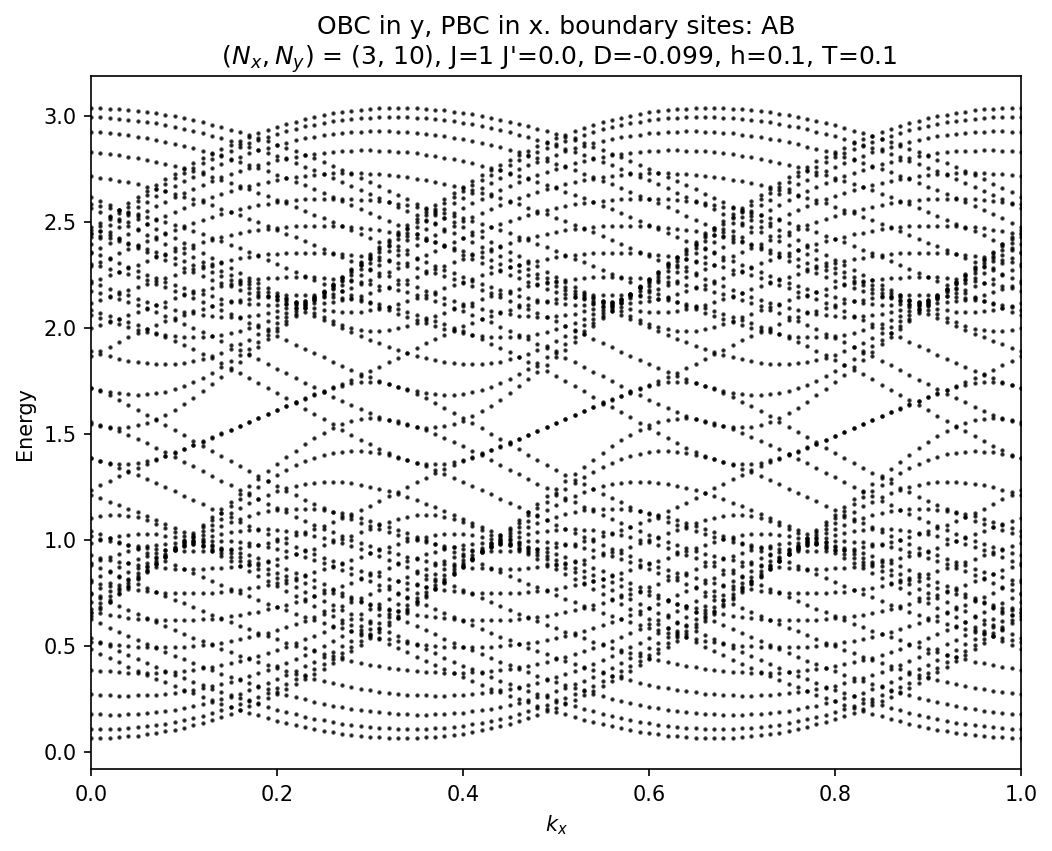

In [28]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(E)):
    # j = i/N
    c = ['r', 'g', 'b', 'c']
    marks = ['o', 'D', 's']
    # colormap viridis
    # ax.scatter(bands[i, :], Er[:,i], color=plt.cm.hsv(j), s=10, alpha=0.8, marker=f'{marks[i%3]}')
    ax.scatter(bands[i, :], Er[:,i], 
        # color=f'{c[i%4]}', s=5, alpha=0.7, marker=f'{marks[i%3]}')
        color='k', s=5, alpha=0.7, marker='.')
    
ax.set_xlabel('$k_x$')
ax.set_ylabel('Energy')
ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(-0.7, 0.7)
title = f"OBC in y, PBC in x. boundary sites: {bc[0]}{bc[1]}\n $(N_x, N_y)$ = ({n}, {m}), J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

# plt.savefig(f'./louvre/cylinder_n{n}_m{m}_J{j}_Jp{J}_D{D}_h{h}_T{T}_{bc[0]}{bc[1]}.png', dpi=100)

plt.show()


In [11]:
k = np.pi/a1/2
E = eigenv(j, J, D, h, k)
print(f'Eigenvalues: {E}')

Eigenvalues: [-2.58836399e+00+6.90572286e-18j  2.18194334e+00-6.82684390e-19j
  2.58836399e+00+7.19474933e-30j  2.58836399e+00+9.71445147e-17j
  2.18194334e+00-2.48143605e-16j  1.59357935e+00+4.84212903e-23j
  1.59357935e+00-4.15918588e-17j -2.58836399e+00-6.30035291e-17j
 -2.18194334e+00-5.51126395e-18j -2.18194334e+00+4.27882663e-17j
 -1.59357935e+00-1.18038346e-29j -1.59357935e+00+6.80715910e-17j
 -4.27994361e-16-1.03339392e-16j -7.34867838e-17-5.18417777e-17j
  1.00000000e+00+6.70950958e-17j -1.00000000e+00-5.55111512e-17j
 -1.00000000e+00+7.48099499e-17j -1.00000000e+00+2.68882139e-17j
  1.00000000e+00+9.02056208e-17j  1.00000000e+00-8.67361738e-18j
  1.00000000e+00-3.72423446e-17j -1.00000000e+00+2.10904832e-16j
  1.00000000e+00+3.44345339e-16j -1.00000000e+00-1.77811885e-16j]


In [51]:
k = np.pi/a1/2
H = hamiltonian(j, J, D, h, k)
with open(f'hamiltonian_{m}x{n}.txt', 'w') as f:
    for i in range(N):
        for j in range(N):
            f.write(f'{H[i,j]} ')
        f.write('\n')

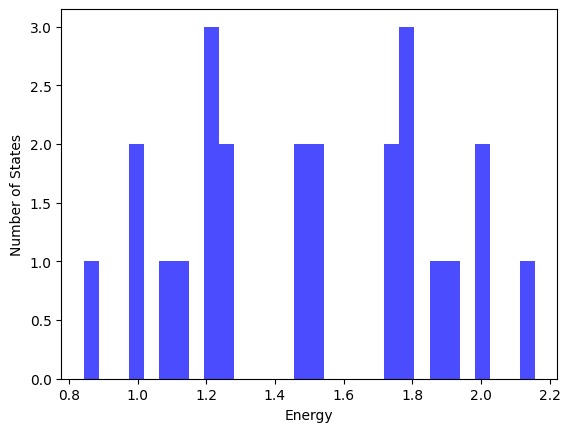

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(E, bins=30, alpha=0.7, color='blue')
ax.set_xlabel('Energy')
ax.set_ylabel('Number of States')

plt.show()

# Armchair OBC

In [ ]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global n, m, N, a1
n = 3 # unit cell number in x direction, need to be even
m = 10 # unit cell number in y direction
N = 2*n*m
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2

def ni(i):
    # new index
    # transform from 0, 1, 2, ..., N-1 to 0, 2, 4, ..., 1, 3, 5, ...
    if i % 2 == 0:
        return int(i/2)
    else:
        return int((i-1)/2 + N/2)
    # return i

def hamiltonian(j, J, d, h, k, d2=-10, boundary_site1='A', boundary_site2='B'):
    
    mat = np.zeros((N,N), dtype=np.complex128)
    
    A = []
    B = []
    for i in range(n*m):
        A.append(i*2)
        B.append(i*2 + 1)
    
    phase = lambda a : np.exp(1j * k * a)
    n2 = 2*n
    if d2 == -10:
        d2 = d
    else: pass
    
    def labels(i):
        
        l = math.floor(i/(2*n))
        row = n2*l 
        rowp = 2*n*((l+1)%m)
        rowm = 2*n*((l-1)%m)
        x, y = (i+n2)%N, (i-n2)%N
        
        return row, rowp, rowm, x, y
        
    ''' Periodic boundary condition '''

    for i in A:
        row, rowp, rowm, x, y = labels(i)
        xi = -1 # 
        
        mat[ni(i), ni(i)] += 3*j+6*J+h
        
        # nearest neighbors
        mat[ni(i), ni(i+1)] += -j*phase(a1)
        mat[ni(i), ni((i-1)%n2+row)] += -j*phase(-a1)
        mat[ni(i), ni((i-2*n+1)%N)] += -j
        
        # next nearest neighbors
        mat[ni(i), ni((i+2)%n2+row)] += (-J-d*1j)*phase(2*a1)
        mat[ni(i), ni((i-2)%n2+row)] += (-J+d*1j)*phase(-2*a1)
        mat[ni(i), ni(x)] += (-J+d*1j)*phase(a1)
        mat[ni(i), ni((x-2)%n2+rowp)] += (-J-d*1j)*phase(-a1)
        mat[ni(i), ni(y)] += (-J-d*1j)*phase(-a1)
        mat[ni(i), ni((y+2)%n2+rowm)] += (-J+d*1j)*phase(a1)
        
    for i in B:
        row, rowp, rowm, x, y = labels(i)
        
        mat[ni(i), ni(i)] = 3*j+6*J+h
        
        # nearest neighbors
        mat[ni(i), ni(i-1)] += -j*phase(-a1)
        mat[ni(i), ni((i+1)%n2+row)] += -j*phase(a1)
        mat[ni(i), ni((i+2*n-1)%N)] += -j
        
        # next nearest neighbors
        mat[ni(i), ni((i+2)%n2+row)] += (-J+d2*1j)*phase(2*a1)
        mat[ni(i), ni((i-2)%n2+row)] += (-J-d2*1j)*phase(-2*a1)
        mat[ni(i), ni(x)] += (-J-d2*1j)*phase(a1)
        mat[ni(i), ni((x-2)%n2+rowp)] += (-J+d2*1j)*phase(-a1)
        mat[ni(i), ni(y)] += (-J+d2*1j)*phase(-a1)
        mat[ni(i), ni((y+2)%n2+rowm)] += (-J-d2*1j)*phase(a1)

    ''' Open boundary condition (in y direction)'''
    
    for i in A[:n]: # first layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni((i-2*n+1)%N)] = 0
        
        mat[ni(i), ni(y)] = 0
        mat[ni(i), ni((y+2)%n2+rowm)] = 0
    
    for i in B[:n]: # second layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni(y)] = 0
        mat[ni(i), ni((y+2)%n2+rowm)] = 0
    
    for i in B[-n:]: # last layer
        row, rowp, rowm, x, y = labels(i)
        mat[ni(i), ni((i+2*n-1)%N)] = 0
        
        mat[ni(i), ni(x)] = 0
        mat[ni(i), ni((x-2)%n2+rowp)] = 0
        
    for i in A[-n:]: # second last layer
        row, rowp, rowm, x, y = labels(i)
        
        mat[ni(i), ni(x)] = 0
        mat[ni(i), ni((x-2)%n2+rowp)] = 0
        
    ''' Different boundary sites '''
    sites_tobe_removed = [0, N]
            
    if boundary_site1 == 'A':
        pass 
    elif boundary_site1 == 'B':
        sites_tobe_removed[0] = n
        for i in B[:n]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(i-1)] = 0
            mat[ni(i), ni((i+1)%n2+row)] = 0
            
            mat[ni(i), ni((i+2)%n2+row)] = 0
            mat[ni(i), ni((i-2)%n2+row)] = 0
            
        for i in A[n:2*n]:
            row, rowp, rowm, x, y = labels(i)
            
            mat[ni(i), ni(y)] = 0
            mat[ni(i), ni((y+2)%n2+rowm)] = 0
    else:
        print('Error: boundary_site1 should be A or B')
        return
    
    if boundary_site2 == 'B':
        pass
    elif boundary_site2 == 'A':
        sites_tobe_removed[1] = N-n
        for i in A[-n:]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(i+1)] = 0
            mat[ni(i), ni((i-1)%n2+row)] = 0
            
            mat[ni(i), ni((i+2)%n2+row)] = 0
            mat[ni(i), ni((i-2)%n2+row)] = 0
            
        for i in B[-2*n:-n]:
            row, rowp, rowm, x, y = labels(i)
            mat[ni(i), ni(x)] = 0
            mat[ni(i), ni((x-2)%n2+rowp)] = 0
    else:
        print('Error: boundary_site2 should be A or B')
        return
        
    return mat[sites_tobe_removed[0]: sites_tobe_removed[1], sites_tobe_removed[0]: sites_tobe_removed[1]]/2
    # print(sites_tobe_removed)
    return mat/2

def delta_function(x, res=100):
    
    e = 2/res
    D = e/(e**2 + x**2) * 1/np.pi
    return D

def eigenv(Jn, JN, D, h, k, d2=-10, boundary_site1='A', boundary_site2='B'):
    '''  setup eigenvalues and eigenvectors
    parameters:
        Jn: float
            nearest neighbor interaction
        JN: float
            next nearest neighbor interaction
        D: float
            Dzyaloshinskii-Moriya interaction
        h: float
            magnetic field
        k: float
            momentum
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_str: np.ndarray
            conjugated eigenvectors
    '''
    H = hamiltonian(Jn, JN, D, h, k, d2, boundary_site1, boundary_site2)
    
    E, U = np.linalg.eig(H)
    # E -= np.min(E)+1e-10 # shift to positive
    # print(f'Eigenvalue: {E}')
    # U_str = np.conjugate(U)
    
    # return E, U, U_str
    return E
    
    
j = 1
J = 0.0
# D = 0.1
# D2 = D
D = -0.1+0.001
D2 = 0.1+0.001
h = 0.1
T = 0.1

k1 = np.pi/a1
spec = np.linspace(0, k1, 101)
# spec = np.linspace(0, 0.25*np.pi, 101)
Erp = []
bc = ['A', 'B'] # boundary condition
for k in spec:
    E = 0
    E = eigenv(j, J, D, h, k, d2=D2, boundary_site1=bc[0], boundary_site2=bc[1])
    # Erp.append(sorted(np.real(E)))
    Erp.append(np.real(E))
Er = np.array(Erp)
bands = np.array([spec] * len(E))/k1
